In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
#home_address = "Buschweg 11, 53229 Bonn, Deutschland"
#home_address = "Sternstraße, 53111 Bonn"
home_address = "Schlesienstraße 5, 53119 Bonn"
target_address = "Berlin, Deutschland"
target_neighborhoods_url = "berlin_ortsteile.csv"

# 1. Geolocation of home address

## Initialize the geolocator

In [3]:
geolocator = Nominatim(user_agent="ny_explorer")

In [4]:
def get_geolocation(address):
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('For address {} the geograpical coordinate are {}, {}.'.format(address,latitude, longitude))  
    return latitude, longitude

In [5]:
## Retrieve geolocation of home address

In [6]:
home_latitude, homelongitude = get_geolocation(home_address)
#print("Geolocation of home address: latitute {} longitude {}.".format(home_latitude, homelongitude))

For address Schlesienstraße 5, 53119 Bonn the geograpical coordinate are 50.74721635, 7.05191705.


# 2. The geolocations of the target city's neighborhoods

In [7]:
target_latitude ,target_longitude = get_geolocation(target_address)
#print("Geolocation of target address: latitute {} longitude {}.".format(target_latitude, target_longitude))

For address Berlin, Deutschland the geograpical coordinate are 52.5170365, 13.3888599.


## Read all neighboorhoods of Berlin

In [8]:
berlin_stadtteile = pd.read_csv(target_neighborhoods_url)
neighborhoods_geolocation = berlin_stadtteile

# add columns for latitude and longitute
neighborhoods_geolocation["Latitude"] = None
neighborhoods_geolocation["Longitude"] = None

neighborhoods_geolocation.rename({"Name" : "Neighborhood"},inplace=True,axis='columns')

neighborhoods_geolocation[:10]

,Neighborhood,Status,Latitude,Longitude
0,Gesundbrunnen,Ortsteil,None,None
1,Hansaviertel,Ortsteil,None,None
2,Mitte,Ortsteil,None,None
3,Moabit,Ortsteil,None,None
4,Tiergarten,Ortsteil,None,None
5,Wedding,Ortsteil,None,None
6,Charlottenburg,Ortsteil,None,None
7,Charlottenburg-Nord,Ortsteil,None,None
8,Grunewald,Ortsteil,None,None
9,Halensee,Ortsteil,None,None


## Next iterate over all neighborhoods in Berlin and retrieve their geolocations

In [9]:
for index,neighborhood in neighborhoods_geolocation.iterrows(): 
    address = "{}, Berlin, DE".format(neighborhood.Neighborhood)
    latitude,    longitude = get_geolocation(address)
    neighborhood.Latitude = latitude
    neighborhood.Longitude = longitude

For address Gesundbrunnen, Berlin, DE the geograpical coordinate are 52.5509201, 13.384846.
For address Hansaviertel, Berlin, DE the geograpical coordinate are 52.5191234, 13.3418725.
For address Mitte, Berlin, DE the geograpical coordinate are 52.5176896, 13.4023757.
For address Moabit, Berlin, DE the geograpical coordinate are 52.5301017, 13.3425422.
For address Tiergarten, Berlin, DE the geograpical coordinate are 52.5097776, 13.3572597.
For address Wedding, Berlin, DE the geograpical coordinate are 52.550123, 13.34197.
For address Charlottenburg, Berlin, DE the geograpical coordinate are 52.515747, 13.3096834.
For address Charlottenburg-Nord, Berlin, DE the geograpical coordinate are 52.5405253, 13.2962663.
For address Grunewald, Berlin, DE the geograpical coordinate are 52.460482150000004, 13.238698511429014.
For address Halensee, Berlin, DE the geograpical coordinate are 52.4972262, 13.2929986.
For address Schmargendorf, Berlin, DE the geograpical coordinate are 52.4789022, 13.29

## Print neighborhoods dataframe with geolocations

In [10]:
neighborhoods_geolocation[:10]

,Neighborhood,Status,Latitude,Longitude
0,Gesundbrunnen,Ortsteil,52.5509,13.3848
1,Hansaviertel,Ortsteil,52.5191,13.3419
2,Mitte,Ortsteil,52.5177,13.4024
3,Moabit,Ortsteil,52.5301,13.3425
4,Tiergarten,Ortsteil,52.5098,13.3573
5,Wedding,Ortsteil,52.5501,13.342
6,Charlottenburg,Ortsteil,52.5157,13.3097
7,Charlottenburg-Nord,Ortsteil,52.5405,13.2963
8,Grunewald,Ortsteil,52.4605,13.2387
9,Halensee,Ortsteil,52.4972,13.293


# 3. Fetch venues for home neighborhood

## For the home location the home neighborhood is explored by means of the Foursquare service venues/explore.

## Define Foursquare Credentials and Version

In [11]:
CLIENT_ID = 'VKSIQER351GE0IFJAR4KV4YOF5QFBDNYSLANPKBNHDLBVRAN' # your Foursquare ID
CLIENT_SECRET = 'GXWOAWMYIT4XIAMH3DAYR2IWVXGGQFK2KLIMMKEVFEKKRUI3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VKSIQER351GE0IFJAR4KV4YOF5QFBDNYSLANPKBNHDLBVRAN
CLIENT_SECRET:GXWOAWMYIT4XIAMH3DAYR2IWVXGGQFK2KLIMMKEVFEKKRUI3


In [12]:
# type your answer here

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, 
    home_latitude, homelongitude,
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VKSIQER351GE0IFJAR4KV4YOF5QFBDNYSLANPKBNHDLBVRAN&client_secret=GXWOAWMYIT4XIAMH3DAYR2IWVXGGQFK2KLIMMKEVFEKKRUI3&v=20180605&ll=50.74721635,7.05191705&radius=500&limit=100'

In [13]:
results = requests.get(url).json()
#results

From the Foursquare lab in the previous module, we know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called torronto_venues.

In [16]:
neighborhoods_geolocation.head()

,Neighborhood,Status,Latitude,Longitude
0,Gesundbrunnen,Ortsteil,52.5509,13.3848
1,Hansaviertel,Ortsteil,52.5191,13.3419
2,Mitte,Ortsteil,52.5177,13.4024
3,Moabit,Ortsteil,52.5301,13.3425
4,Tiergarten,Ortsteil,52.5098,13.3573


## Add the home neighborhood / locatin to the neighborhood data frame

In [17]:
home_row = { "Neighborhood" : "Home",
           "Latitude" : home_latitude,
           "Longitude" : homelongitude}
neighborhoods_geolocation=neighborhoods_geolocation.append(home_row, ignore_index=True)
neighborhoods_geolocation.set_index("Neighborhood",inplace=True)
neighborhoods_geolocation.tail()


,Status,Latitude,Longitude
Neighborhood,,,
Oberschöneweide,Ortsteil,52.4625,13.5235
Plänterwald,Ortsteil,52.4795,13.4788
Rahnsdorf,Ortsteil,52.4359,13.7018
Schmöckwitz,Ortsteil,52.3757,13.6489
Home,NaN,50.7472,7.05192


In [18]:
# type your answer here
venues = getNearbyVenues(names=neighborhoods_geolocation.index,#neighborhoods_geolocation['Neighborhood'],
                                   latitudes=neighborhoods_geolocation['Latitude'],
                                   longitudes=neighborhoods_geolocation['Longitude']
                                  )

Gesundbrunnen
Hansaviertel
Mitte
Moabit
Tiergarten
Wedding
Charlottenburg
Charlottenburg-Nord
Grunewald
Halensee
Schmargendorf
Westend
Wilmersdorf
Friedrichshain
Kreuzberg
Alt-Hohenschönhausen
Falkenberg
Fennpfuhl
Friedrichsfelde
Karlshorst
Lichtenberg
Malchow
Neu-Hohenschönhausen
Rummelsburg
Wartenberg
Biesdorf
Hellersdorf
Kaulsdorf
Mahlsdorf
Marzahn
Britz
Buckow
Gropiusstadt
Neukölln
Rudow
Blankenburg
Blankenfelde
Buch
Französisch Buchholz
Heinersdorf
Karow
Niederschönhausen
Pankow
Prenzlauer Berg
Rosenthal
Stadtrandsiedlung Malchow
Weißensee
Wilhelmsruh
Borsigwalde
Frohnau
Heiligensee
Hermsdorf
Konradshöhe
Lübars
Märkisches Viertel
Reinickendorf
Tegel
Waidmannslust
Wittenau
Falkenhagener Feld
Gatow
Hakenfelde
Haselhorst
Kladow
Siemensstadt
Spandau
Staaken
Wilhelmstadt
Dahlem
Lankwitz
Lichterfelde
Nikolassee
Steglitz
Wannsee
Zehlendorf
Friedenau
Lichtenrade
Mariendorf
Marienfelde
Schöneberg
Tempelhof
Adlershof
Altglienicke
Alt-Treptow
Baumschulenweg
Bohnsdorf
Friedrichshagen
Grünau
J

#### Let's check the size of the resulting dataframe

In [19]:
print(venues.shape)
venues.tail()

(1415, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1410,Home,50.747216,7.051917,China Imbiss Kanton,50.744006,7.053739,Chinese Restaurant
1411,Home,50.747216,7.051917,Schützenhof,50.743848,7.055070,Beer Garden
1412,Home,50.747216,7.051917,H Tannenbusch Mitte,50.749976,7.046482,Tram Station
1413,Home,50.747216,7.051917,Im Pool,50.751438,7.049776,Garden
1414,Home,50.747216,7.051917,Boogie @ Terasse,50.751444,7.049664,Garden


# 4. For this home neighborhood and for the target city location all the  neighborhoods all the venues are fetched, categories counted and hot encoded.

Let's check how many venues were returned for each neighborhood

In [20]:
venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adlershof,8,8,8,8,8,8
Alt-Hohenschönhausen,10,10,10,10,10,10
Alt-Treptow,26,26,26,26,26,26
Baumschulenweg,6,6,6,6,6,6
Biesdorf,6,6,6,6,6,6


In [21]:
## One hot encoding

In [22]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.tail()

,Zoo Exhibit,ATM,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bavarian Restaurant,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Brasserie,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Butcher,Cafeteria,Café,Canal,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Creperie,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Fishing Store,Flower Shop,Food & Drink Shop,Food Court,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Kurdish Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Lighting Store,Liquor Store,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Nightclub,Opera House,Organic Grocery,Outdoor Event Space,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Café,Pet Store,Pharmacy,Pide Place,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Post Office,Print Shop,Pub,Record Shop,Restaurant,River,Rock Climbing Spot,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Syrian Restaurant,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Waterfront,Windmill,Wine Bar,Wine Shop,Yoga Studio
1410,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Home,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1411,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Home,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [23]:
venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped.head()

,Neighborhood,Zoo Exhibit,ATM,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bavarian Restaurant,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Brasserie,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Butcher,Cafeteria,Café,Canal,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Creperie,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Fishing Store,Flower Shop,Food & Drink Shop,Food Court,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Kurdish Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Lighting Store,Liquor Store,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Opera House,Organic Grocery,Outdoor Event Space,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Café,Pet Store,Pharmacy,Pide Place,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Post Office,Print Shop,Pub,Record Shop,Restaurant,River,Rock Climbing Spot,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Syrian Restaurant,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Waterfront,Windmill,Wine Bar,Wine Shop,Yoga Studio
0,Adlershof,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

# 6. Find most similar neighborhoods

Define home neighborhoods as "centroid"

In [24]:
centroid_home = venues_grouped.loc[venues_grouped["Neighborhood"]=="Home"].drop("Neighborhood",axis="columns").values

## Calculate euclidean distances from every neighborhood in target city to home neighborhood

In [25]:
from sklearn.metrics.pairwise import euclidean_distances
distances = euclidean_distances(venues_grouped.drop("Neighborhood",axis="columns").values,centroid_home)

print("{} distances calculated. That is one distance value per neighborhood".format(distances.shape[0]))

95 distances calculated. That is one distance value per neighborhood


## Print top ten nearest neighborhoods
Of course the home neighboorhood should have distance 0. Please check.

In [26]:
#m join the neighborhood names
distances = pd.DataFrame(distances,columns=["Distance"])
distances["Neighboorhood"] = venues_grouped["Neighborhood"]
distances.sort_values(by="Distance",ascending=True, inplace=True)
distances.set_index("Neighboorhood",inplace=True)
distances.head(11)

,Distance
Neighboorhood,
Home,5.268356e-09
Gesundbrunnen,4.767213e-01
Charlottenburg,4.777280e-01
Tiergarten,4.859127e-01
Halensee,4.886217e-01
Moabit,4.886617e-01
Mitte,4.931386e-01
Hellersdorf,4.960159e-01
Friedrichshain,4.990679e-01


# Print the top ten recommended target neighboorhoods

In [27]:
recommended_neighborhoods = distances.iloc[1:11]
recommended_neighborhoods.insert(0, 'Rank', range(1, 1 + len(recommended_neighborhoods)))
recommended_neighborhoods

,Rank,Distance
Neighboorhood,,
Gesundbrunnen,1,0.476721
Charlottenburg,2,0.477728
Tiergarten,3,0.485913
Halensee,4,0.488622
Moabit,5,0.488662
Mitte,6,0.493139
Hellersdorf,7,0.496016
Friedrichshain,8,0.499068
Rummelsburg,9,0.499433


## Show the distribution of Distances

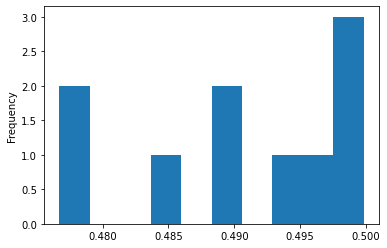

In [28]:
recommended_neighborhoods.Distance.plot(kind="hist")

## Create a map showing the top ten neighborhoods
Each neighborhood has a marker with its own color.
Every marker has its label with the name of the neighborhood and its euclidean distance.

In [29]:
# create map
map_clusters = folium.Map(location=[target_latitude ,target_longitude], zoom_start=11)

# set color scheme for the clusters
kclusters=10
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
i = 0
for index, row in distances.iloc[1:11].iterrows():
    i = i + 1
    label = folium.Popup("Place {}: Neighborhood {} with euclidean distance {:.2f}".format(i,index,row.Distance), parse_html=True)
    #print(str(index))
    lat = neighborhoods_geolocation.loc[index,"Latitude"]
    lon = neighborhoods_geolocation.loc[index,"Longitude"]
    #lon = neighborhoods.loc[neighborhoods.index==row.index,"Longitude"].values
    #print(lat)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[i-1],
        fill=True,
        fill_color=rainbow[i-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters